In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [2]:
def load_apms_data(filepath):
    return pd.read_csv(filepath, sep='\t')

In [14]:
apms_data = load_apms_data("data/raw/apms.tsv")

In [15]:
def summarize_data(df):
    print("Shape of the dataset:", df.shape)
    print("\nColumn names:\n", df.columns.tolist())
    print("\nBasic stats:\n", df[['SpecSum', 'AvgSpec', 'AvgP.x']].describe())
    print("\nTop baits:\n", df['Bait'].value_counts().head())


In [16]:
summarize_data(apms_data)

Shape of the dataset: (3097, 17)

Column names:
 ['Bait', 'Prey', 'PreyGene.x', 'Spec', 'SpecSum', 'AvgSpec', 'NumReplicates.x', 'ctrlCounts', 'AvgP.x', 'MaxP.x', 'TopoAvgP.x', 'TopoMaxP.x', 'SaintScore.x', 'logOddsScore', 'FoldChange.x', 'BFDR.x', 'boosted_by.x']

Basic stats:
            SpecSum      AvgSpec       AvgP.x
count  3097.000000  3097.000000  3097.000000
mean     36.364223     9.091056     0.608034
std      85.253818    21.313455     0.404223
min       0.000000     0.000000     0.000000
25%       4.000000     1.000000     0.250000
50%      12.000000     3.000000     0.750000
75%      38.000000     9.500000     1.000000
max    2312.000000   578.000000     1.000000

Top baits:
 Bait
HDAC2      1098
SMARCA4     946
DNMT3A      587
KDM6A       466
Name: count, dtype: int64


In [17]:
def plot_distributions(df):
    plt.figure(figsize=(14, 4))
    for i, col in enumerate(['SpecSum', 'AvgSpec', 'AvgP.x']):
        plt.subplot(1, 3, i+1)
        sns.histplot(df[col], bins=30, kde=True)
        plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()

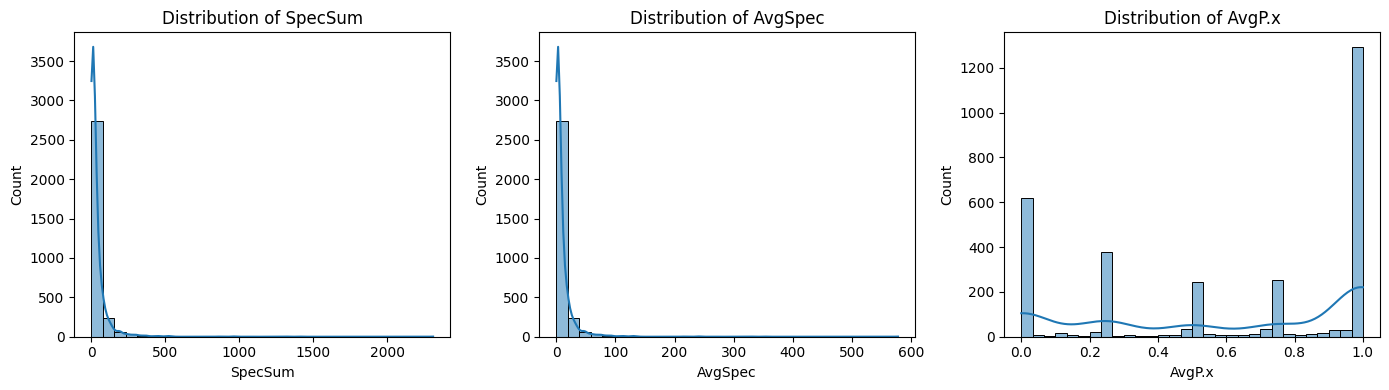

In [18]:
plot_distributions(apms_data)

In [19]:
def pca_clustering(df, n_clusters=4):
    features = ['SpecSum', 'AvgSpec', 'AvgP.x']
    X = df[features].copy()
    X_scaled = StandardScaler().fit_transform(X)

    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    
    df['PCA1'], df['PCA2'], df['Cluster'] = X_pca[:,0], X_pca[:,1], labels
    
    # Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='tab10')
    plt.title('PCA + KMeans Clustering')
    plt.show()
    
    return df

In [20]:
def top_preys_by_cluster(df, top_n=5):
    for cluster in sorted(df['Cluster'].unique()):
        print(f"\nTop {top_n} Preys in Cluster {cluster}:")
        top_preys = df[df['Cluster'] == cluster]['PreyGene.x'].value_counts().head(top_n)
        print(top_preys)


/Users/sl3223/miniconda3/envs/cm4ai-secms-tutorial/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


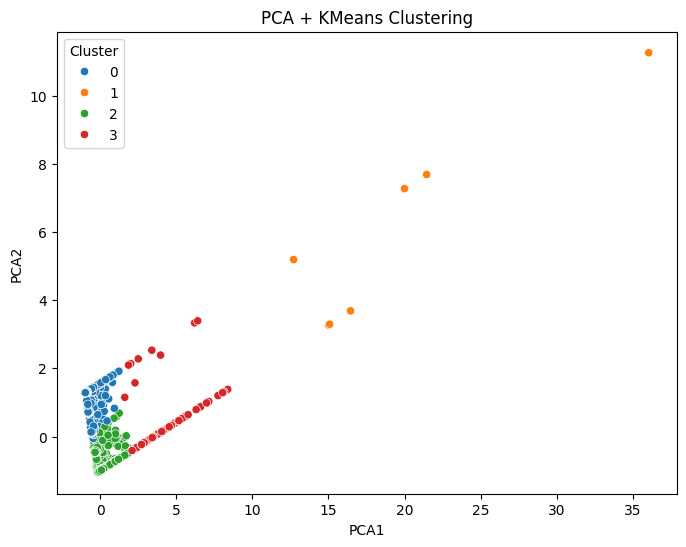

In [21]:
apms_data_pca = pca_clustering(apms_data, n_clusters=4)

In [22]:
top_preys_by_cluster(apms_data_pca, top_n=5)


Top 5 Preys in Cluster 0:
PreyGene.x
HS90A_HUMAN    4
RS27A_HUMAN    4
CHERP_HUMAN    4
TRY3_HUMAN     4
CPSF5_HUMAN    4
Name: count, dtype: int64

Top 5 Preys in Cluster 1:
PreyGene.x
MYH9_HUMAN     4
MYH10_HUMAN    1
MYH14_HUMAN    1
SMCA4_HUMAN    1
Name: count, dtype: int64

Top 5 Preys in Cluster 2:
PreyGene.x
RL5_HUMAN     4
RL14_HUMAN    4
RL23_HUMAN    4
RAN_HUMAN     4
RS4X_HUMAN    4
Name: count, dtype: int64

Top 5 Preys in Cluster 3:
PreyGene.x
HNRPU_HUMAN    3
MYH10_HUMAN    3
MYH14_HUMAN    3
LMNA_HUMAN     2
SPTB2_HUMAN    2
Name: count, dtype: int64


In [23]:
def print_apms_summary_report(apms_data):
    print("🧪🔍 CM4AI AP-MS Dataset Summary\n" + "="*40, flush=True)

    # 1. Number of unique Baits
    n_baits = apms_data["Bait"].nunique()
    print(f"\n🎯 Number of unique bait proteins: {n_baits}", flush=True)
    bait_counts = apms_data["Bait"].value_counts()
    for bait, count in bait_counts.items():
        print(f"  - {bait}: {count} interactions", flush=True)

    # 2. Number of unique Preys
    n_preys = apms_data["Prey"].nunique()
    print(f"\n🧬 Number of unique prey proteins (Uniprot IDs): {n_preys}", flush=True)

    # 3. Average and distribution of spectral counts
    if "SpecSum" in apms_data.columns:
        specsum_mean = apms_data["SpecSum"].mean()
        print(f"\n📊 Mean SpecSum (Total spectral counts per prey): {specsum_mean:.2f}", flush=True)
        print("  Spectral count summary statistics:", flush=True)
        print(apms_data["SpecSum"].describe(), flush=True)

    # 4. Top 10 interactions by SAINT score (if available)
    saint_col = [col for col in apms_data.columns if "SaintScore" in col]
    if saint_col:
        print(f"\n🏅 Top 10 interactions by {saint_col[0]}:", flush=True)
        top_hits = apms_data.sort_values(by=saint_col[0], ascending=False).head(10)
        for _, row in top_hits.iterrows():
            print(f"  - Bait: {row['Bait']}, Prey: {row['PreyGene.x']}, Score: {row[saint_col[0]]:.3f}", flush=True)
    else:
        print("\n⚠️ SAINT score column not found in dataset.", flush=True)

    # 5. Control count summary
    if "ctrlCounts" in apms_data.columns:
        ctrl_counts_present = apms_data["ctrlCounts"].notna().sum()
        print(f"\n🧪 Control spectral counts present in {ctrl_counts_present} entries.", flush=True)
    else:
        print("\n⚠️ Control count column 'ctrlCounts' not found.", flush=True)

In [25]:
print_apms_summary_report(apms_data)

🧪🔍 CM4AI AP-MS Dataset Summary

🎯 Number of unique bait proteins: 4
  - HDAC2: 1098 interactions
  - SMARCA4: 946 interactions
  - DNMT3A: 587 interactions
  - KDM6A: 466 interactions

🧬 Number of unique prey proteins (Uniprot IDs): 1372

📊 Mean SpecSum (Total spectral counts per prey): 36.36
  Spectral count summary statistics:
count    3097.000000
mean       36.364223
std        85.253818
min         0.000000
25%         4.000000
50%        12.000000
75%        38.000000
max      2312.000000
Name: SpecSum, dtype: float64

🏅 Top 10 interactions by SaintScore.x:
  - Bait: DNMT3A, Prey: SAP18_HUMAN, Score: 1.000
  - Bait: HDAC2, Prey: MDC1_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: CPSF6_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: SF3B3_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: FL2D_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: RBM39_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: SPTN1_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: FLII_HUMAN, Score: 1.000
  - Bait: KDM6A, Prey: SRSF1_HUMAN, Score